# Titanic : Machine Learning from Disaster

In this notebook, we are going to create an algorithm which will predict  if a passenger of the titanic survived or not. This algorithm will learn from train dataset and then it will predict if each passenger of the test dataset survived. 

The plan to do that is the following one :

1. Exploration of data
2. Features engineering
3. Cross validation testing of the model
4. Prediction on test data & submission on kaggle

## Imports and useful functions

In [1]:
import pandas as pd
import matplotlib
import pydot
import re

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import numpy as np
import sklearn
import seaborn as sns

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.svm import SVC  
from sklearn.tree import export_graphviz, DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.preprocessing import StandardScaler


import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier

from IPython.display import display

In [5]:
#path of datasets
path_train = os.path.join(os.path.dirname(os.path.abspath('__file__')), 'datasets/train.csv')
path_test = os.path.join(os.path.dirname(os.path.abspath('__file__')), 'datasets/test.csv')

def display_confusion_matrix(sample_test, prediction, score=None):
    cm = metrics.confusion_matrix(sample_test, prediction)
    plt.figure(figsize=(9,9))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square=True, cmap='Blues_r')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    if score:
        all_sample_title = 'Accuracy Score: {0}'.format(score)
        plt.title(all_sample_title, size = 15)
    print(metrics.classification_report(sample_test, prediction))
    
def visualize_tree(tree, feature_names):
    """Create tree png using graphviz"""
    with open("dt.dot", 'w') as f:
        export_graphviz(tree, out_file=f,
                        feature_names=feature_names)

    command = ["dot", "-Tpng", "dt.dot", "-o", "dt.png"]
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")
        
def model_tuning(model, param_grid):
    
    gc_cv = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
    gc_cv.fit(X_train_sample_train, Y_train_sample_train)
    
    return gc_cv.best_params_, gc_cv.best_score_, gc_cv.cv_results_

def standardize(df):
    
    standardize_df = df.copy()
    
    target = None
    if 'Survived' in standardize_df.columns.tolist():
        target = standardize_df['Survived'] # Separating out the target before standardizing
        standardize_df = standardize_df.drop(['Survived'],  axis=1)

    # Standardizing the features
    scaled_values = StandardScaler().fit_transform(standardize_df.values)
    standardize_df = pd.DataFrame(scaled_values, index=standardize_df.index, columns=standardize_df.columns)
    if target is not None:
        standardize_df = standardize_df.join(target)
    
    return standardize_df

## 1. Data exploration

In [6]:
#create dataframe for training dataset and print ten first rows as preview
train_df_raw = pd.read_csv(path_train)
train_df_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Compute some basical statistics on the dataset
train_df_raw.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


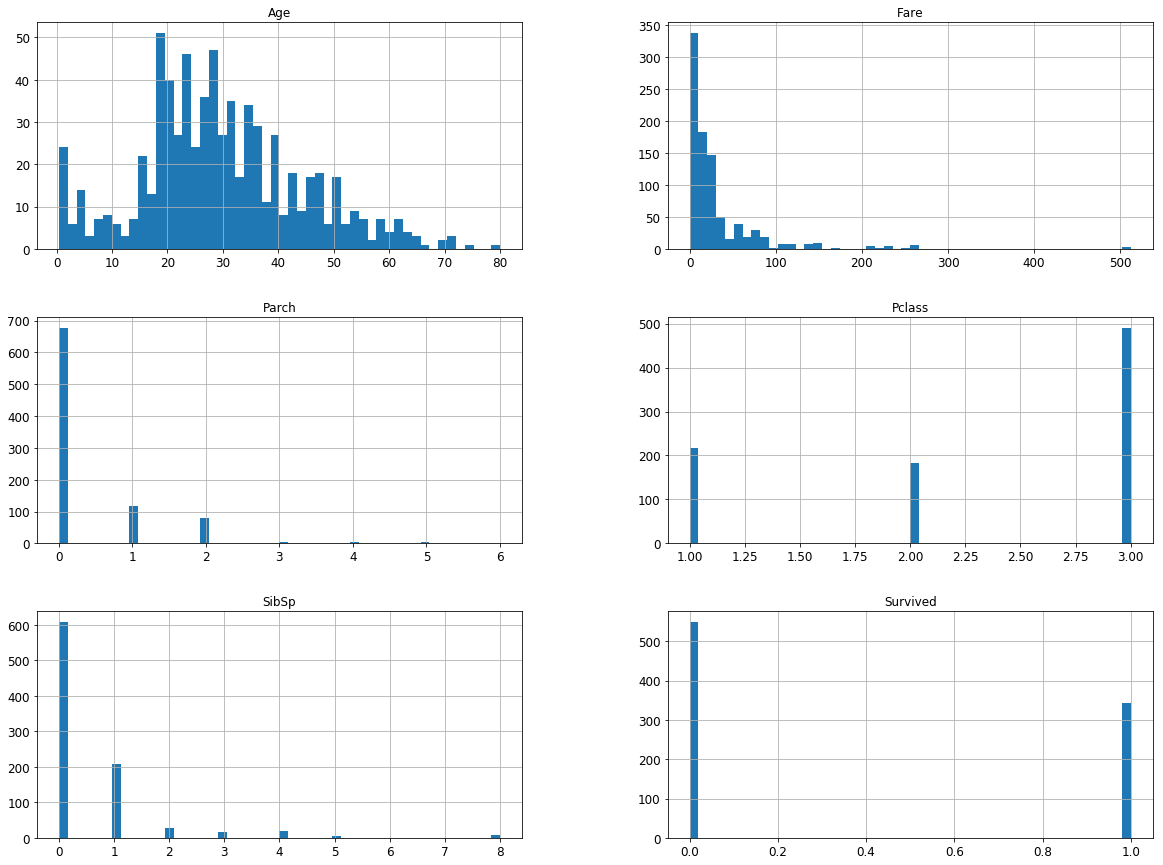

In [5]:
# Let's plot some histograms to have a previzualisation of some of the data ...
train_df_raw.drop(['PassengerId'], 1).hist(bins=50, figsize=(20,15))
plt.show()

With this first exploration, we can see that :

* Only aproximately 35% of passengers survived ...
* More than the half of passengers are in the lowest class (pclass = 3)
* Most of the fare tickets are below 50
* Majority of passengers are alone (sibsp and parch)

## 2. Features engineering

In [7]:
def preprocess_data(df):
    
    # Replace string data by numeric data
    df['Cabin'].fillna('U0', inplace=True)
    df['Sex'] = df['Sex'].replace('male', 1)
    df['Sex'] = df['Sex'].replace('female', 0)
    df['Embarked'] = df['Embarked'].replace('S', 0)
    df['Embarked'] = df['Embarked'].replace('C', 1)
    df['Embarked'] = df['Embarked'].replace('Q', 2)
    df['Embarked'].fillna(0, inplace=True) # because there is approximately 80% of 0 in embarked column

    # Replace NaN data in age column by mean age of passengers
    mean_age = df['Age'].mean()
    df['Age'].fillna(mean_age, inplace=True)
    
    df['Fare'] = df['Fare'].interpolate()

    # Let's work on 'Name' column : we find the title in the name and extract it on a new column 'Title'
    mapping_title = {title: pos for pos, title in enumerate(set([name.split('.')[0].split(',')[1].strip() for name in df['Name']]))}
    df['Title'] = pd.Series((mapping_title[name2.split('.')[0].split(',')[1].strip()] for name2 in df['Name']), index=df.index)
    df = df.drop(columns=['Name'])

    #Creation of a deck column corresponding to the letter contained in the cabin value
    mapping_deck = {title: pos for pos, title in enumerate(set([cab[:1] for cab in df['Cabin']]))}
    df['Deck'] = pd.Series((mapping_deck[cab2[:1]] for cab2 in df['Cabin']), index=df.index)

    # Modify the cabin column to keep only the cabin number
    cabin_numbers = list()
    for cab3 in df['Cabin']:
        if len(cab3) != 1:
            cabin_numbers.append(int(cab3[1:].strip()) if len(cab3[1:]) <= 3 else int(cab3[len(cab3)-2:].strip()))
        else:
            cabin_numbers.append(0)

    # df['Cabin'] = pd.Series(cabin_numbers, index=df.index)
    df = df.drop(['Cabin'], 1)

    # Modify the ticket column to keep only the ticket number
    ticket_numbers = list()
    for ticket in df['Ticket']:
        try:
            ticket_numbers.append(int(ticket))
        except ValueError:
            splitted = ticket.split(' ')
            if len(splitted) == 1:
                ticket_numbers.append(0)
            else:
                ticket_numbers.append(int(splitted[len(splitted)-1]))

    df['Ticket'] = pd.Series(ticket_numbers, index=df.index)
        
    return df

## 3. Cross validation of model on train dataset

In [11]:
# Let's divide the train dataset in two datasets to evaluate perfomance of machine learning models used
train_df = train_df_raw.copy()
X_train = train_df.drop(['Survived'], 1)
Y_train = train_df['Survived']

# Split dataset for prediction
X_train_sample_train, X_train_sample_test, Y_train_sample_train, Y_train_sample_test = sklearn.model_selection.train_test_split(X_train,
                                                                                                                                Y_train, 
                                                                                                                                test_size=0.5, 
                                                                                                                                random_state=42)

X_train_sample_train = preprocess_data(X_train_sample_train)
X_train_sample_test = preprocess_data(X_train_sample_test)
X_train_sample_train = standardize(X_train_sample_train)
X_train_sample_test = standardize(X_train_sample_test)

X_train_sample_train.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,Deck
236,-0.853639,-0.428546,0.709492,1.157631,0.302883,-0.457604,-0.424916,-0.127256,-0.539952,0.573558,0.461449
88,-1.423412,-1.643215,-1.409460,-0.467340,1.843261,2.120039,-0.434648,4.052062,-0.539952,-1.208797,-1.561652
757,1.152117,-0.428546,0.709492,-0.854239,-0.467306,-0.457604,-0.421458,-0.382952,-0.539952,0.573558,0.461449
117,-1.311768,-0.428546,0.709492,-0.003063,0.302883,-0.457604,-0.446575,-0.215427,-0.539952,0.573558,0.461449
125,-1.280969,0.786123,0.709492,-1.318516,0.302883,-0.457604,-0.459561,-0.387507,1.040828,1.642971,0.461449


### 3.1 Try several models

              precision    recall  f1-score   support

           0       0.82      0.89      0.85       267
           1       0.81      0.70      0.75       179

   micro avg       0.81      0.81      0.81       446
   macro avg       0.81      0.79      0.80       446
weighted avg       0.81      0.81      0.81       446



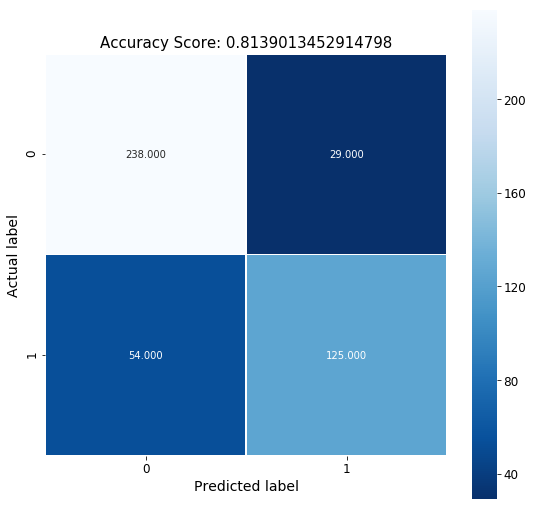

In [12]:
# Create and train model on train data sample
logisticRegr = LogisticRegression(random_state=42)
logisticRegr.fit(X_train_sample_train, Y_train_sample_train)

# Predict for test data sample
logistic_prediction_train = logisticRegr.predict(X_train_sample_test)

# Compute error between predicted data and true response and display it in confusion matrix
score = metrics.accuracy_score(Y_train_sample_test, logistic_prediction_train)
display_confusion_matrix(Y_train_sample_test, logistic_prediction_train, score=score)

              precision    recall  f1-score   support

           0       0.80      0.90      0.85       267
           1       0.81      0.66      0.73       179

   micro avg       0.80      0.80      0.80       446
   macro avg       0.81      0.78      0.79       446
weighted avg       0.80      0.80      0.80       446



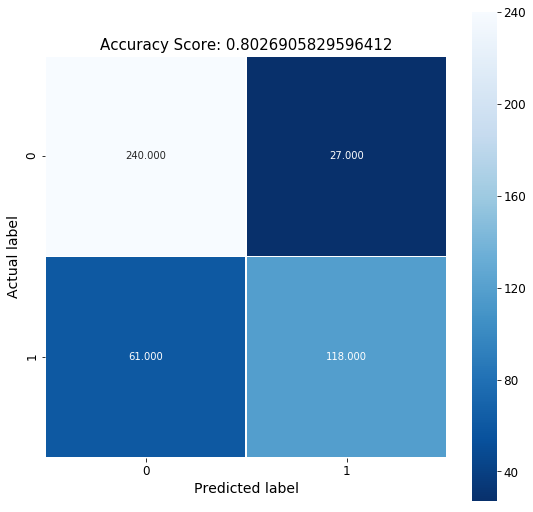

In [13]:
# Create and train model on train data sample
dt = DecisionTreeClassifier(min_samples_split=15, min_samples_leaf=8, random_state=42)
dt.fit(X_train_sample_train, Y_train_sample_train)

# Predict for test data sample
dt_prediction_train = dt.predict(X_train_sample_test)

# Compute error between predicted data and true response and display it in confusion matrix
score = metrics.accuracy_score(Y_train_sample_test, dt_prediction_train)
display_confusion_matrix(Y_train_sample_test, dt_prediction_train, score=score)

In [14]:
visualize_tree(dt, X_train_sample_test.columns)
! dot -Tpng dt.dot > dt.png

![title](dt.png)

              precision    recall  f1-score   support

           0       0.84      0.88      0.86       267
           1       0.80      0.74      0.77       179

   micro avg       0.82      0.82      0.82       446
   macro avg       0.82      0.81      0.81       446
weighted avg       0.82      0.82      0.82       446



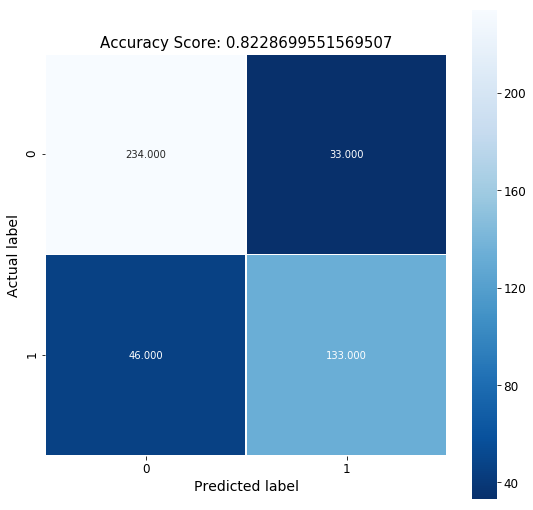

In [15]:
# Create and train model on train data sample
rf = RandomForestClassifier(n_estimators=50, random_state = 42)
rf.fit(X_train_sample_train, Y_train_sample_train)

# Predict for test data sample
rf_prediction_train = rf.predict(X_train_sample_test)

# Compute error between predicted data and true response and display it in confusion matrix
score = metrics.accuracy_score(Y_train_sample_test, rf_prediction_train)
display_confusion_matrix(Y_train_sample_test, rf_prediction_train, score=score)

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       267
           1       0.79      0.71      0.75       179

   micro avg       0.81      0.81      0.81       446
   macro avg       0.81      0.79      0.80       446
weighted avg       0.81      0.81      0.81       446



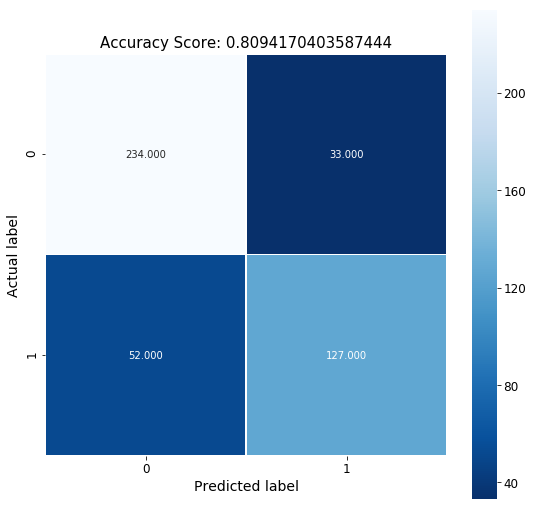

In [16]:
# Create and train model on train data sample
vot = VotingClassifier([('dt', dt), ('lr', logisticRegr), ('rf', rf)], voting='soft')
vot.fit(X_train_sample_train, Y_train_sample_train)

# Predict for test data sample
vot_prediction_train = vot.predict(X_train_sample_test)

# Compute error between predicted data and true response and display it in confusion matrix
score = metrics.accuracy_score(Y_train_sample_test, vot_prediction_train)
display_confusion_matrix(Y_train_sample_test, vot_prediction_train, score=score)

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       267
           1       0.81      0.67      0.73       179

   micro avg       0.80      0.80      0.80       446
   macro avg       0.80      0.78      0.79       446
weighted avg       0.80      0.80      0.80       446



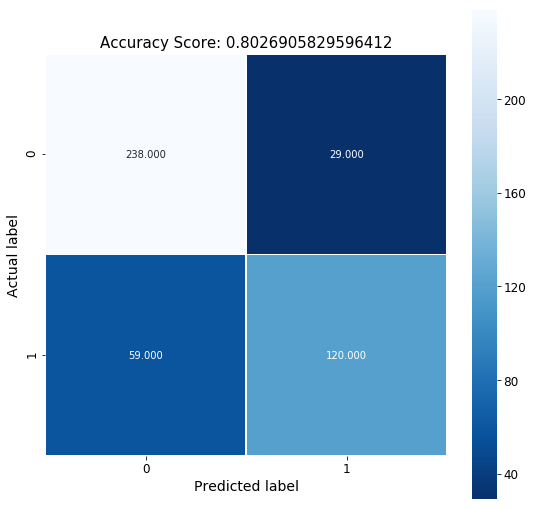

In [36]:
# First try with a random forest with all default parameters
boost = XGBClassifier(random_state=42) # replace the sckitlearn class here to try other models
# model.fit(X_train_sample_train, Y_train_sample_train, early_stopping_rounds=1000, eval_set=[(X_train_sample_test, Y_train_sample_test)], verbose=False)
boost.fit(X_train_sample_train, Y_train_sample_train)

# Predict for test data sample
boost_prediction_train = boost.predict(X_train_sample_test)

# Compute error between predicted data and true response and display it in confusion matrix
score = metrics.accuracy_score(Y_train_sample_test, boost_prediction_train)

display_confusion_matrix(Y_train_sample_test, boost_prediction_train, score=score)

### 3.2 Select one model

#### *Let's try to tune one model*

In [57]:
param_grid_model = {'learning_rate': [0.1, 0.01, 0.001], 'min_child_weight': [2, 4, 8], 'max_depth': [5, 8, 10], 'gamma': [1, 4, 8, 0]}

best_params_model, best_precision_model, result = model_tuning(model=boost, param_grid=param_grid_model)
print(best_params_model, best_precision_model)

{'gamma': 1, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 4} 0.8202247191011236


              precision    recall  f1-score   support

           0       0.84      0.89      0.86       267
           1       0.82      0.74      0.78       179

   micro avg       0.83      0.83      0.83       446
   macro avg       0.83      0.81      0.82       446
weighted avg       0.83      0.83      0.83       446



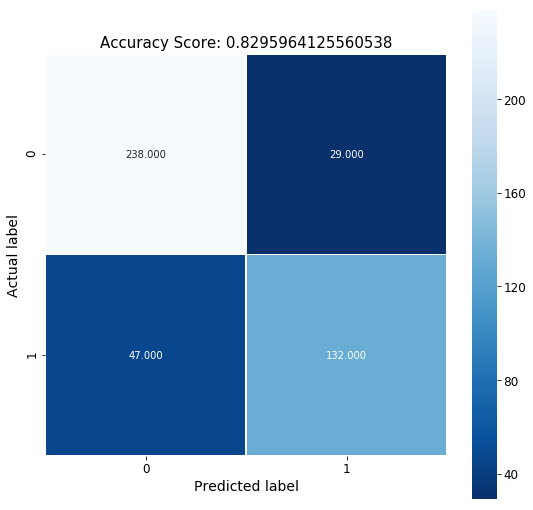

In [58]:
model_tuned = XGBClassifier(n_estimators=50, n_jobs=-1, random_state=42, **best_params_model) # replace the sckitlearn class here to try other models
model_tuned.fit(X_train_sample_train, Y_train_sample_train)

# Predict for test data sample
model_tuned_prediction_train = model_tuned.predict(X_train_sample_test)

# Compute error between predicted data and true response and display it in confusion matrix
display_confusion_matrix(Y_train_sample_test, model_tuned_prediction_train, score=metrics.accuracy_score(Y_train_sample_test, model_tuned_prediction_train))

#### *Tuning the model indeed increased accuracy, let's apply the model on test data now !*

## 4. Apply on test dataset and submit on kaggle 

In [32]:
test_df_raw = pd.read_csv(path_test)
test_df = test_df_raw.copy()
X_test = preprocess_data(test_df)
X_test = standardize(X_test)
X_train = preprocess_data(X_train)
X_train = standardize(X_train)

In [33]:
# Create and train model on train data sample
model_test = XGBClassifier(n_estimators=100, n_jobs=-1, random_state=42, **best_params_model) # replace the sckitlearn class here to try other models
model_test.fit(X_train, Y_train)

# Predict for test data sample
model_test_prediction_test = model_test.predict(X_test)

result_df_xgb = test_df_raw.copy()
result_df_xgb['Survived'] = model_test_prediction_test.astype(int)

result_df_xgb.head()
result_df_xgb.to_csv('submission.csv', columns=['PassengerId', 'Survived'], index=False)

#### *Precision obtained on kaggle : 0.79425 !** 🎉*